# Maximum Entropy Forecasting Pipeline

This notebook demonstrates the full pipeline:
1. Generate relevant variables for a forecasting question
2. Generate probability/expectation estimates using natural language format
3. Build a maximum entropy distribution from the estimates

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
from dotenv import load_dotenv

load_dotenv()

# Check API key is set
assert os.getenv("OPENROUTER_API_KEY"), "Set OPENROUTER_API_KEY in .env file"

## Step 1: Set up the LLM client and generators

In [12]:
from calibrated_response.llm.openrouter import OpenRouterClient
from calibrated_response.generation.variable_generator import VariableGenerator
from calibrated_response.generation.natural_estimate_generator import NaturalEstimateGenerator

# Initialize the LLM client
llm = OpenRouterClient(
    model="google/gemini-2.5-pro",
    providers=["Google"],  # Route to Google for best Gemini performance
)

# Initialize generators
var_gen = VariableGenerator(llm)
est_gen = NaturalEstimateGenerator(llm)

## Step 2: Define the forecasting question

In [13]:
question = """Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?"""

print(f"Forecasting question: {question}")

Forecasting question: Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?


## Step 3: Generate relevant variables

In [14]:
# Generate variables that might influence the forecast
variables = var_gen.generate(question, n_variables=15)

print(f"Generated {len(variables)} variables:\n")
for v in variables:
    print(f"  - {v.name} ({v.type.value}): {v.description}")
    if hasattr(v, 'lower_bound') and hasattr(v, 'upper_bound'):
        unit = getattr(v, 'unit', '') or ''
        print(f"    Domain: [{v.lower_bound}, {v.upper_bound}] {unit}")

Generated 15 variables:

  - ai_bubble_bursts_by_2030 (binary): Whether a significant, rapid, and sustained decline in AI-related market valuations and venture capital investment occurs by the end of 2030.
  - annual_ai_software_revenue (continuous): The total global market revenue for AI-specific software and platforms in the year 2029, indicating successful monetization.
    Domain: [100000000000.0, 2000000000000.0] USD
  - agi_breakthrough_achieved (binary): Whether a consensus is reached among leading AI labs that a system with general, human-like problem-solving capabilities has been demonstrated by 2030.
  - major_ai_safety_incident (binary): Whether a widely reported catastrophic event directly attributable to an autonomous AI system, resulting in over $1 billion in damages or significant loss of life, occurs by 2030.
  - annual_vc_investment_ai (continuous): The total global venture capital investment in AI startups in the peak year before 2030.
    Domain: [50000000000.0, 1000

## Step 4: Generate estimates using natural language format

In [15]:
selected_vars = variables

estimates = []
# Generate estimates in natural language format
for batch in range(5):
    batch_estimates = est_gen.generate(
        question=question,
        variables=selected_vars,
        num_estimates=50,
    )
    estimates.extend(batch_estimates)

print(f"Generated {len(estimates)} estimates:\n")
for est in estimates:
    print(f"  {est.to_query_estimate()}")

Generated 250 estimates:

  P(ai_bubble_bursts_by_2030 = True) = 0.4
  E[annual_ai_software_revenue] = 750000000000.0
  P(agi_breakthrough_achieved = True) = 0.15
  P(major_ai_safety_incident = True) = 0.35
  E[annual_vc_investment_ai] = 300000000000.0
  P(llm_performance_plateau = True) = 0.6
  E[fortune500_ai_adoption_rate] = 65.0
  E[market_cap_top_ai_companies] = 20000000000000.0
  P(strict_ai_regulation_passed = True) = 0.7
  E[training_cost_sota_model] = 1000000000.0
  E[ai_job_displacement_rate] = 5.0
  P(major_ai_company_failure = True) = 0.25
  P(global_recession_occurs = True) = 0.65
  P(us_china_chip_conflict = True) = 0.45
  E[ai_global_energy_share] = 4.0
  P(ai_bubble_bursts_by_2030 = True | llm_performance_plateau = True) = 0.65
  P(ai_bubble_bursts_by_2030 = True | annual_ai_software_revenue < 300000000000.0) = 0.75
  P(ai_bubble_bursts_by_2030 = True | agi_breakthrough_achieved = True) = 0.1
  P(ai_bubble_bursts_by_2030 = True | global_recession_occurs = True) = 0.55
 

In [ ]:
# with open("maxent_llm_cache_large.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache_large.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

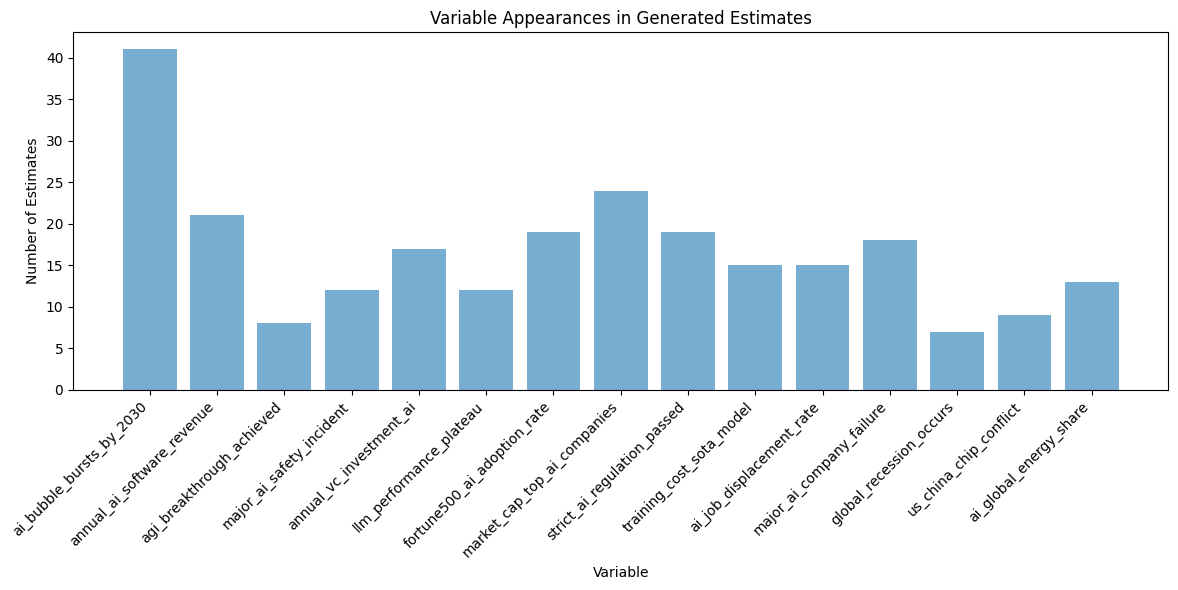

In [21]:
var_names = [v.name for v in variables]
var_appearances = {name: 0 for name in var_names}
for est in estimates:
    if hasattr(est, 'variable'):
        var_appearances[est.variable] += 1
    elif hasattr(est, 'proposition'):
        var_appearances[est.proposition.variable] += 1
#Generate a histogram of variable appearances in estimates
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(var_appearances.keys(), var_appearances.values(), color="C0", alpha=0.6)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Variable")
plt.ylabel("Number of Estimates")
plt.title("Variable Appearances in Generated Estimates")
plt.tight_layout()
plt.show()

C:\Users\amdic\AppData\Local\Temp\ipykernel_40996\882180484.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


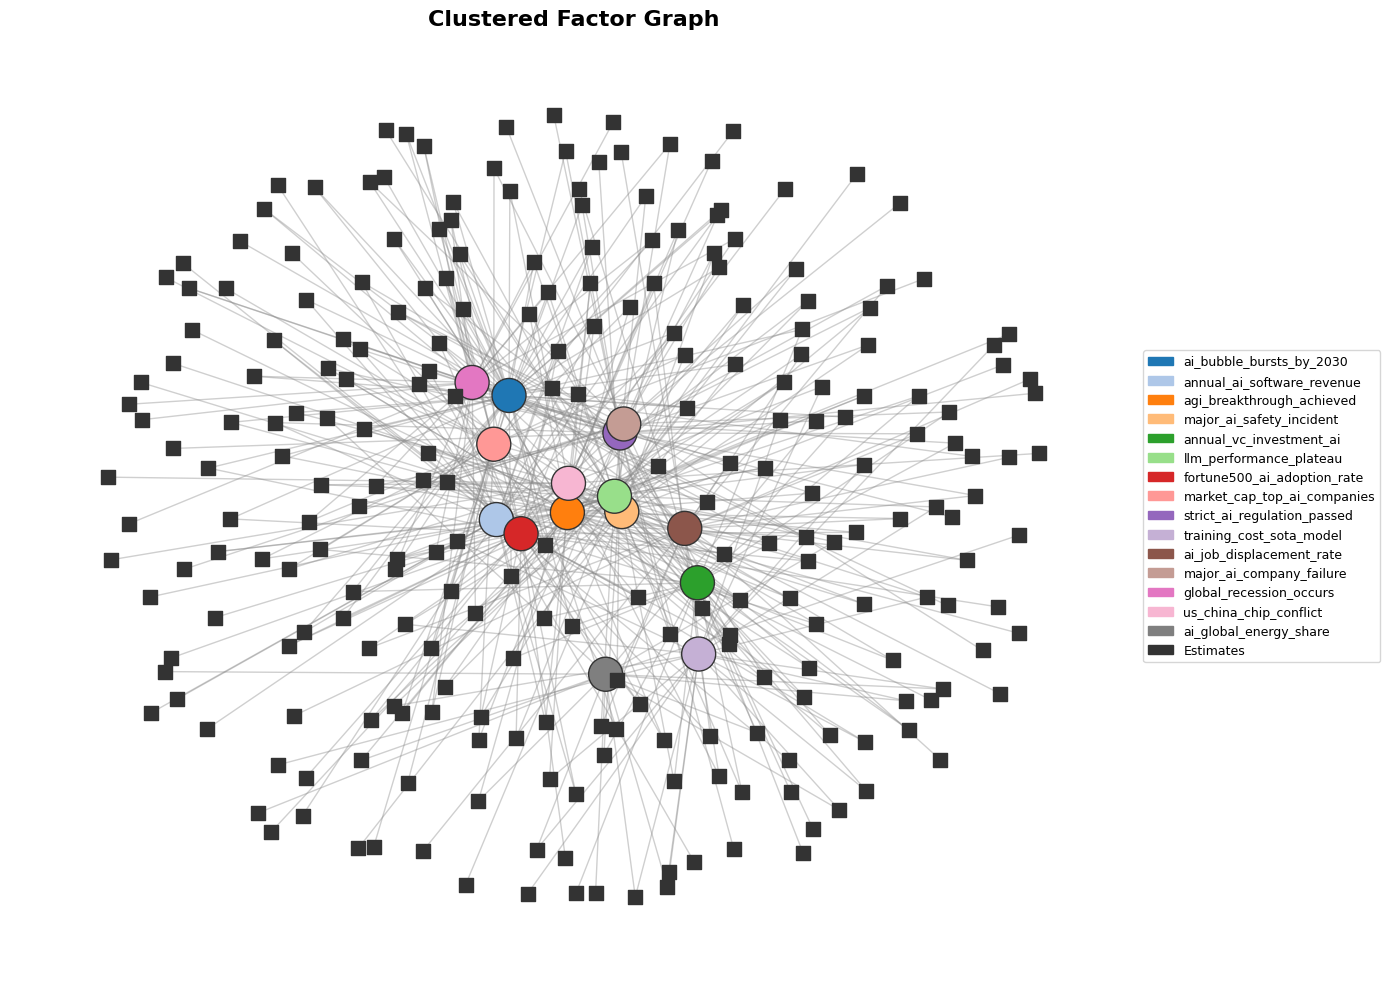

In [19]:
from calibrated_response.visualization.factor_graph import plot_clustered_factor_graph
G, fig = plot_clustered_factor_graph(variables, estimates)
fig.show()

C:\Users\amdic\AppData\Local\Temp\ipykernel_40996\3294866815.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_int.show()


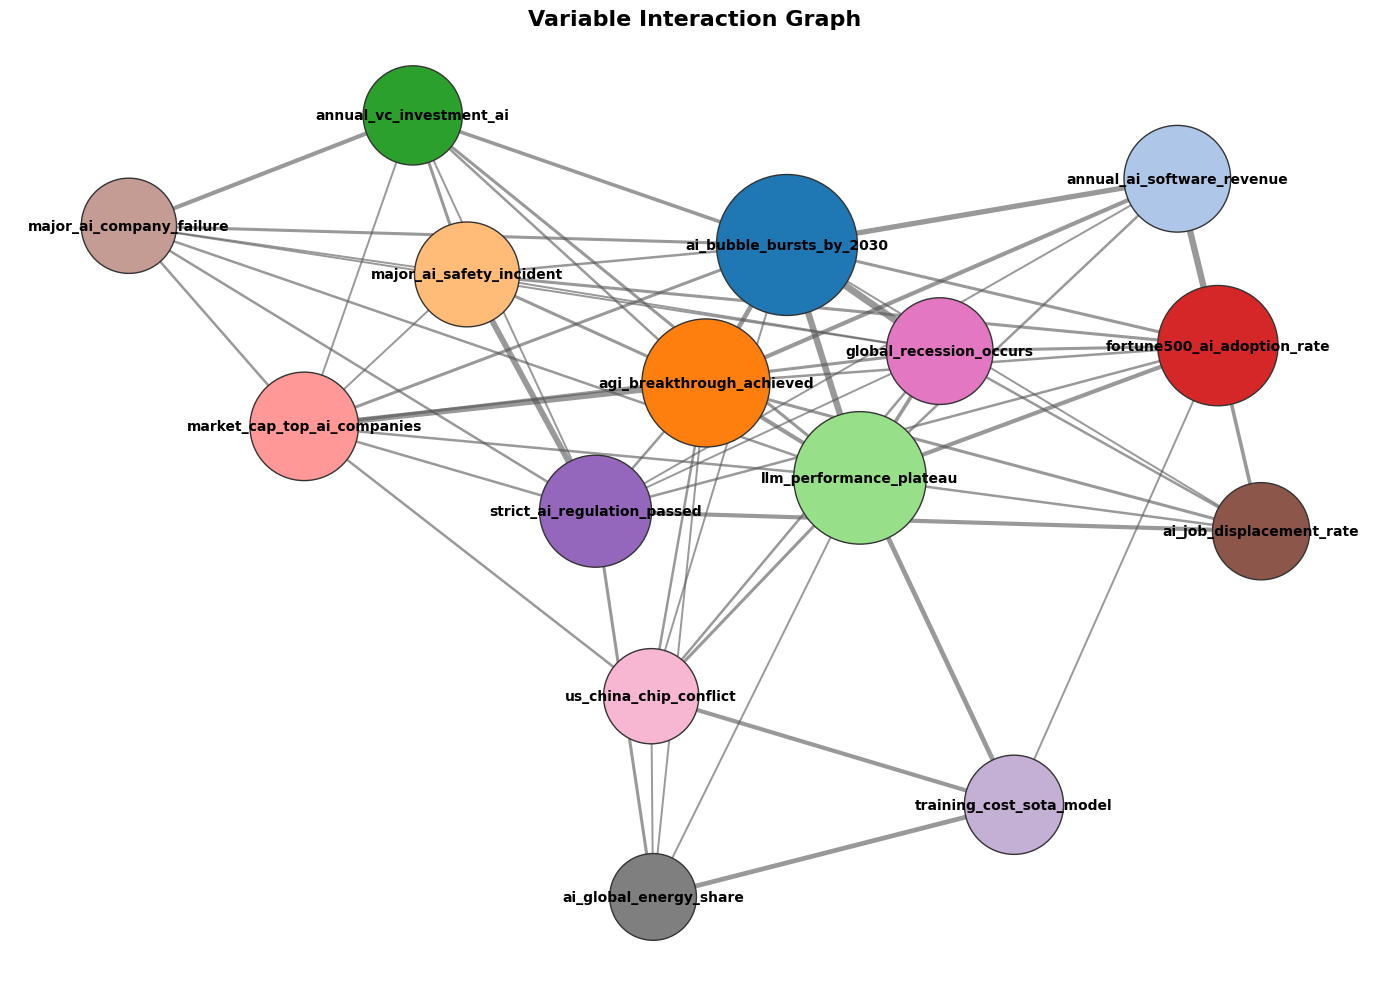

In [22]:
from calibrated_response.visualization.factor_graph import plot_variable_interaction_graph
G_int, fig_int = plot_variable_interaction_graph(variables, estimates)
fig_int.show()

C:\Users\amdic\AppData\Local\Temp\ipykernel_40996\3377554119.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


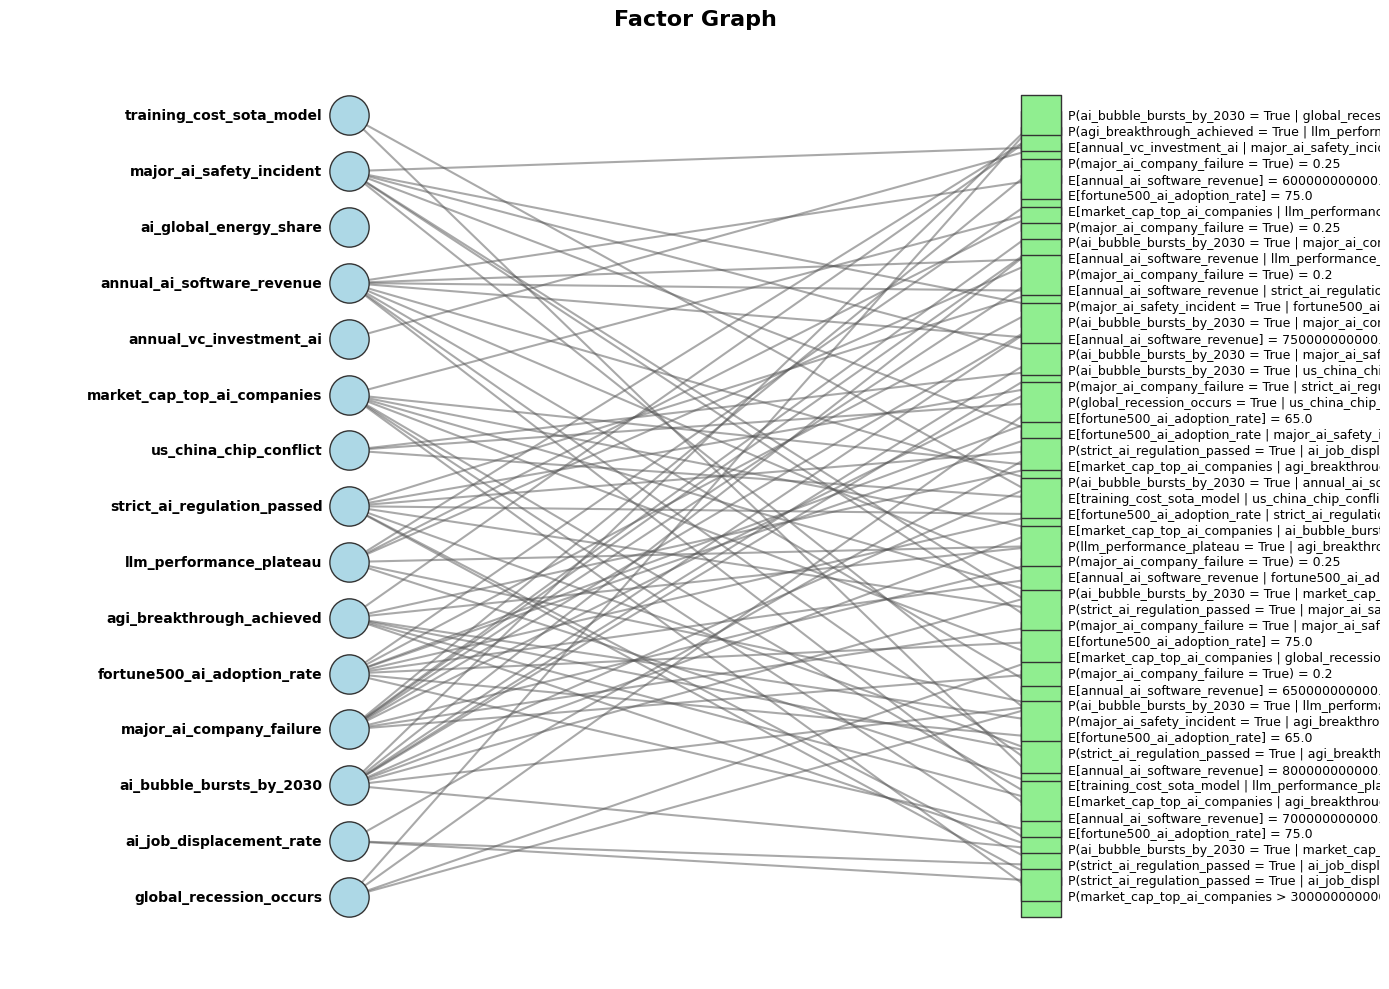

In [23]:
from calibrated_response.visualization.factor_graph import plot_factor_graph
G, fig = plot_factor_graph(variables, estimates[1::5])
fig.show()


In [8]:
print(variables)
for estimate in estimates:
    print(estimate.to_query_estimate())

[BinaryVariable(name='ai_bubble_bursts_by_2030', description="Whether a significant, rapid, and sustained market correction in AI-related assets occurs by the end of 2030, marking the 'burst' of the current AI investment bubble.", type=<VariableType.BINARY: 'binary'>), ContinuousVariable(name='annual_ai_vc_funding', description='Total global venture capital funding invested into private AI companies in a given year.', type=<VariableType.CONTINUOUS: 'continuous'>, lower_bound=10.0, upper_bound=1000.0, unit='billions_usd'), ContinuousVariable(name='ai_revenue_top_companies', description='Total annual revenue directly attributable to AI products and services from the top 20 public technology companies.', type=<VariableType.CONTINUOUS: 'continuous'>, lower_bound=0.1, upper_bound=20.0, unit='trillions_usd'), BinaryVariable(name='benchmark_performance_plateau', description='Whether the rate of improvement on key, broad AI capability benchmarks (e.g., MMLU, HELM) falls below 5% year-over-year

In [25]:
from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.maxent_solver import JAXSolverConfig
from calibrated_response.models.variable import VariableType

config = JAXSolverConfig(
    num_chains=2048,
    num_iterations=1500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.001,
    l2_regularization=1e-1,
    mean_initialisation=False,
    continuous_prior="gaussian",
    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    indicator_sharpness=20.0,
    # roughness_gamma=1e-1,
)


from calibrated_response.maxent_large.features import (
    FeatureSpec,
    MomentFeature,
    SoftThresholdFeature,
)
extra_constraints = []
# for idx, var in enumerate(variables):
#     if var.type == VariableType.CONTINUOUS:
#         # extra_constraints.append((MomentFeature(var_idx=idx, order=2), 0.25))
#         #Constrain marginals to decay to 0 at the bounds (if known), to improve extrapolation outside the training distribution
#         extra_constraints.extend([
#             (SoftThresholdFeature(var_idx=idx, threshold=0.05, direction="less", sharpness=config.indicator_sharpness), 0.0),
#             (SoftThresholdFeature(var_idx=idx, threshold=0.95, direction="greater", sharpness=config.indicator_sharpness), 0.0),
#         ])

builder = DistributionBuilder(variables=variables, 
                              estimates=estimates, 
                              extra_feature_constraints=extra_constraints,
                              solver_config=config)

# Build for AI bubble bursts (the solver trains once; marginals for all variables are in info)
target_variable = variables[0].name
print(target_variable)
distribution, info = builder.build(target_variable=target_variable)
    
print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")
# print(f"Roughness matrix used: {info['roughness_matrix_used']}")

ai_bubble_bursts_by_2030
[MaxEntSolver] iter   50  max_err=0.524675  mean_err=0.124671  mean_squared_err=0.031240  accept=0.668  step_size=0.17201
[MaxEntSolver] iter  100  max_err=0.564080  mean_err=0.118442  mean_squared_err=0.027885  accept=0.639  step_size=0.13227
[MaxEntSolver] iter  150  max_err=0.594320  mean_err=0.112453  mean_squared_err=0.025767  accept=0.625  step_size=0.12424
[MaxEntSolver] iter  200  max_err=0.619039  mean_err=0.106620  mean_squared_err=0.023878  accept=0.631  step_size=0.11671
[MaxEntSolver] iter  250  max_err=0.664895  mean_err=0.101595  mean_squared_err=0.021812  accept=0.634  step_size=0.10963
[MaxEntSolver] iter  300  max_err=0.668528  mean_err=0.099592  mean_squared_err=0.020809  accept=0.625  step_size=0.10298
[MaxEntSolver] iter  350  max_err=0.696705  mean_err=0.094775  mean_squared_err=0.019612  accept=0.680  step_size=0.09673
[MaxEntSolver] iter  400  max_err=0.707614  mean_err=0.092199  mean_squared_err=0.018425  accept=0.663  step_size=0.09086

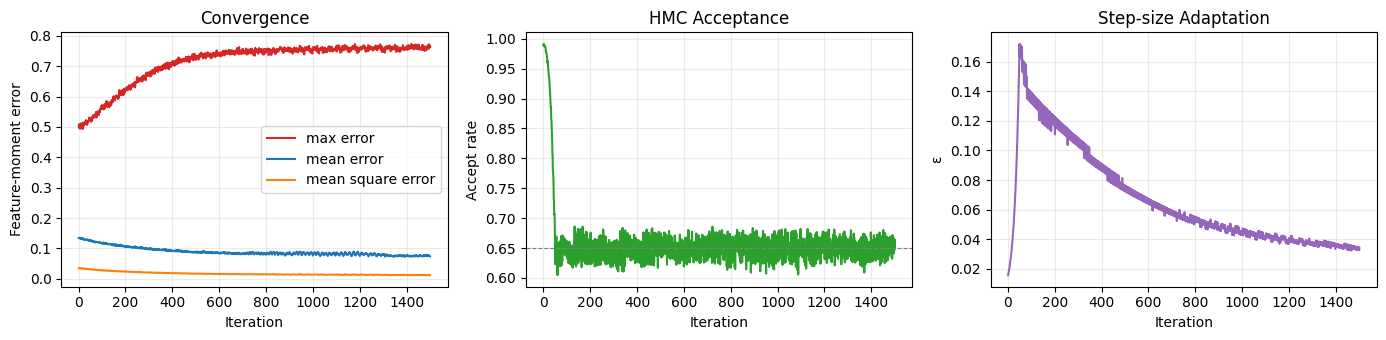

Final max error:  0.76418
Final mean error: 0.07372
Final accept rate: 0.663


In [26]:
import numpy as np
import matplotlib.pyplot as plt

history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].plot(history["iteration"], history["mean_squared_error"], label="mean square error", color="C1")

axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [27]:
model = info['energy_model']
import jax
samples = model.sample_original(n_samples=int(3e3))

In [28]:
print(samples.shape)

(3000, 15)


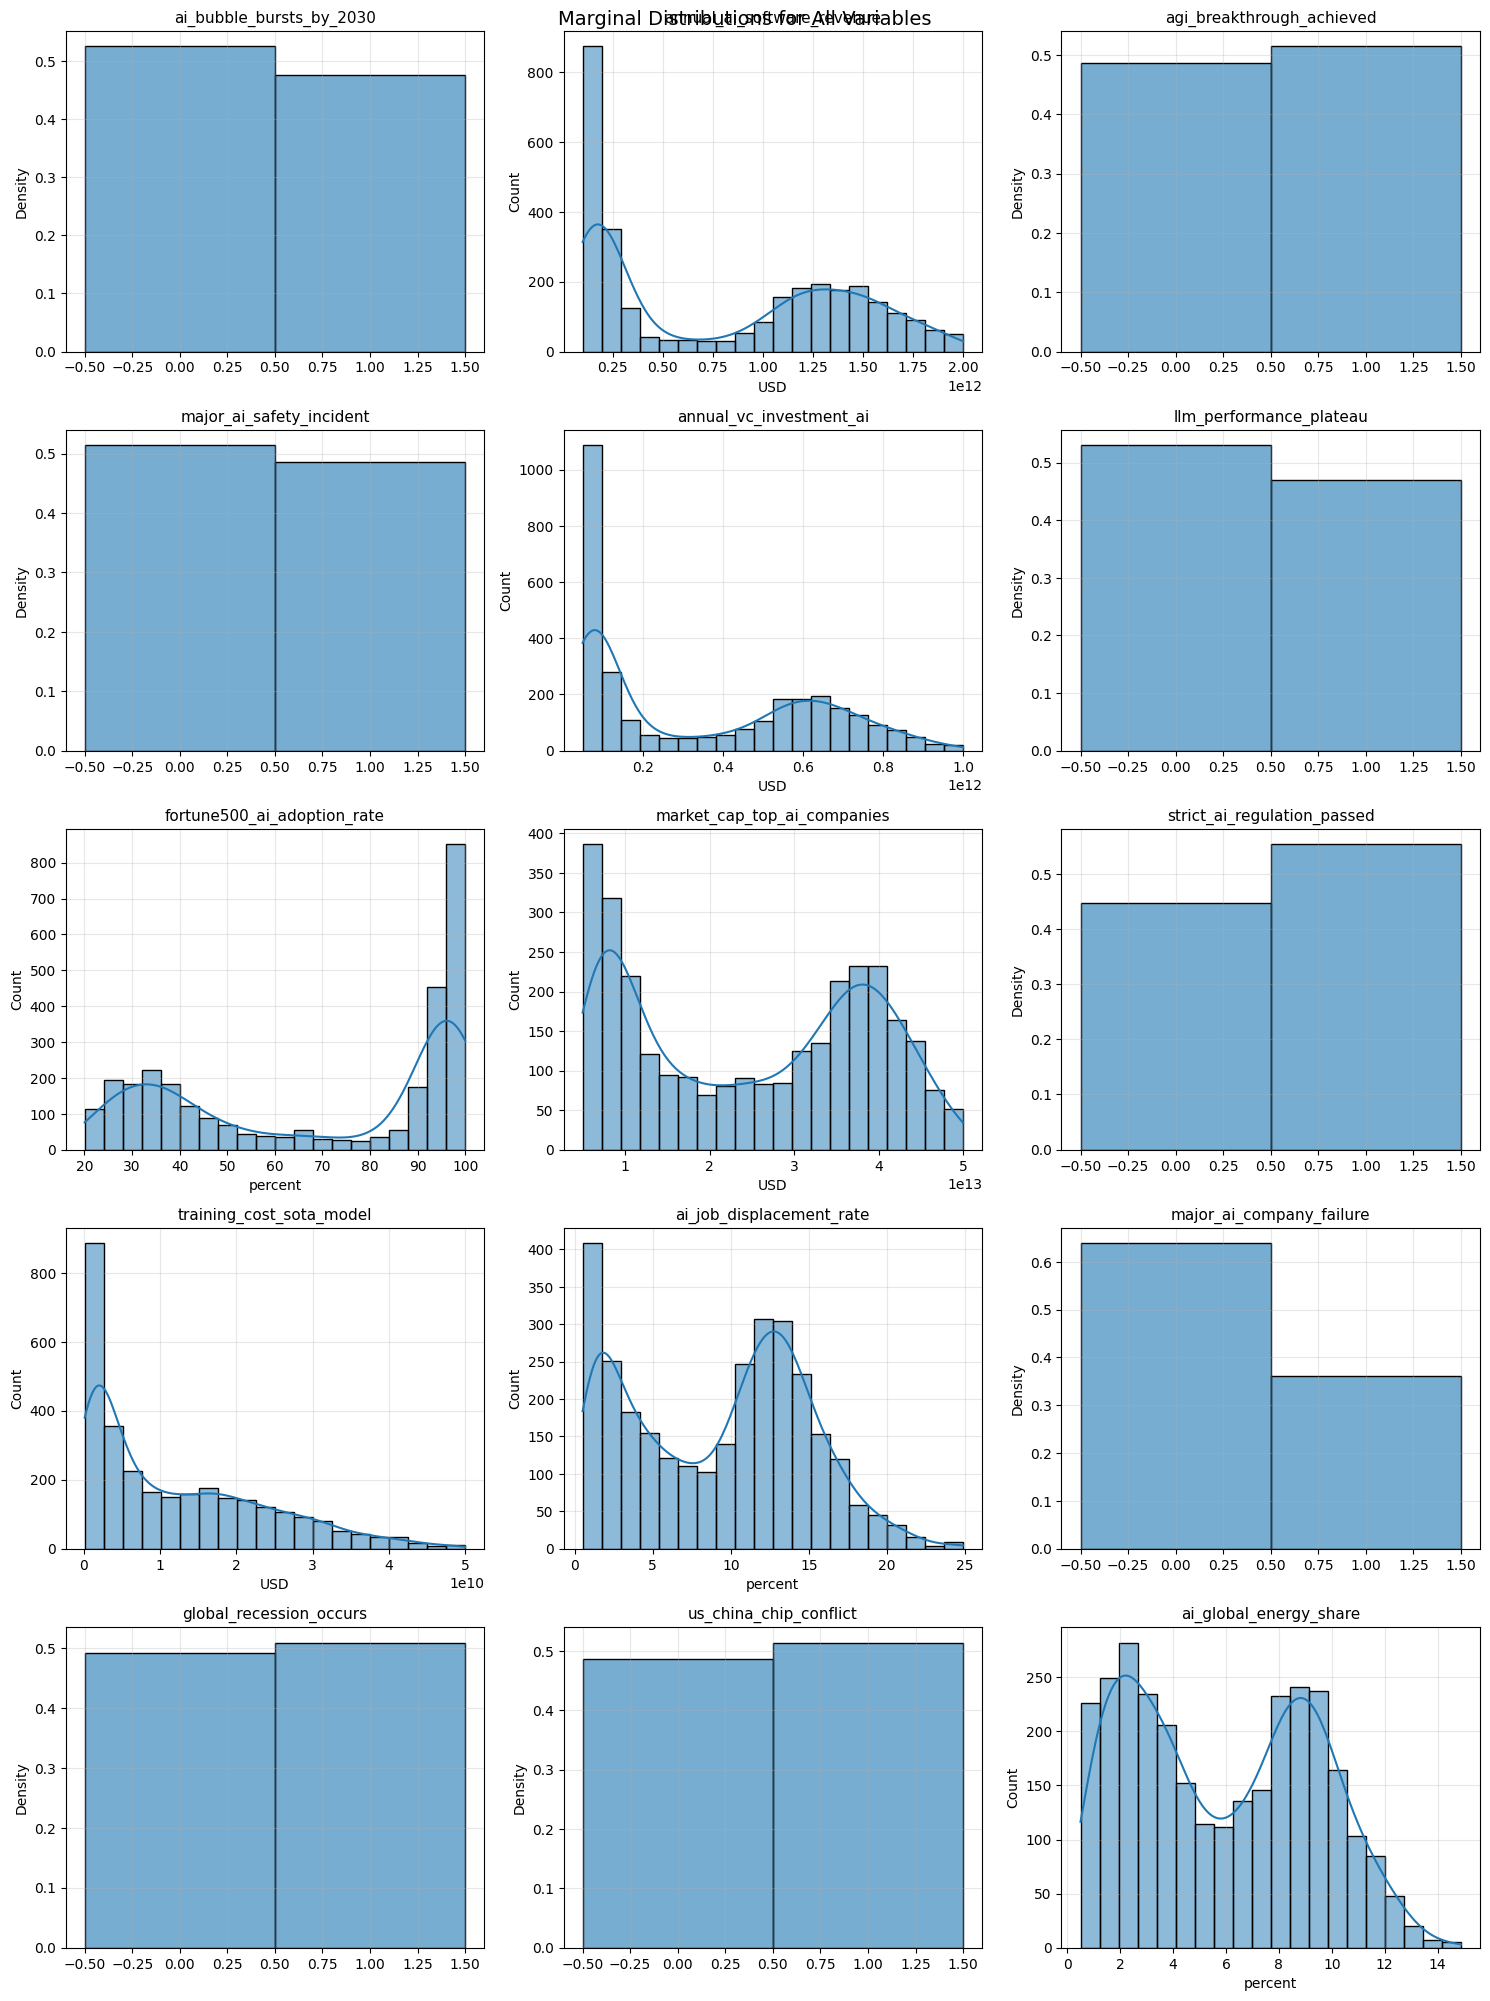

In [29]:
import seaborn as sns
from calibrated_response.models.variable import VariableType


# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    if variables[idx].type == VariableType.BINARY:
        sns.histplot(samples[:, idx], bins=[-0.5, 0.5, 1.5], ax=axes[idx], color="C0", alpha=0.6, stat="density")
        # axes[idx].set_xticks([0, 1])
        # axes[idx].set_xticklabels(["False", "True"])
        # axes[idx].hist(samples[:, idx], bins=[-0.5, 0.5, 1.5], color="C0", alpha=0.6, density=True)
    else:
        sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
        
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

0: ai_bubble_bursts_by_2030: mean=0.489, std=0.308
1: annual_ai_software_revenue: mean=804363763712.000, std=619730960384.000
2: agi_breakthrough_achieved: mean=0.508, std=0.304
3: major_ai_safety_incident: mean=0.491, std=0.295
4: annual_vc_investment_ai: mean=347094646784.000, std=286074011648.000
5: llm_performance_plateau: mean=0.486, std=0.297
6: fortune500_ai_adoption_rate: mean=68.778, std=29.635
7: market_cap_top_ai_companies: mean=24828461449216.000, std=14091167989760.000
8: strict_ai_regulation_passed: mean=0.533, std=0.295
9: training_cost_sota_model: mean=12091954176.000, std=11551528960.000
10: ai_job_displacement_rate: mean=9.217, std=5.692
11: major_ai_company_failure: mean=0.422, std=0.290
12: global_recession_occurs: mean=0.503, std=0.291
13: us_china_chip_conflict: mean=0.505, std=0.289
14: ai_global_energy_share: mean=5.894, std=3.472


Text(0.5, 1.0, 'Joint Distribution of annual_ai_software_revenue and annual_vc_investment_ai')

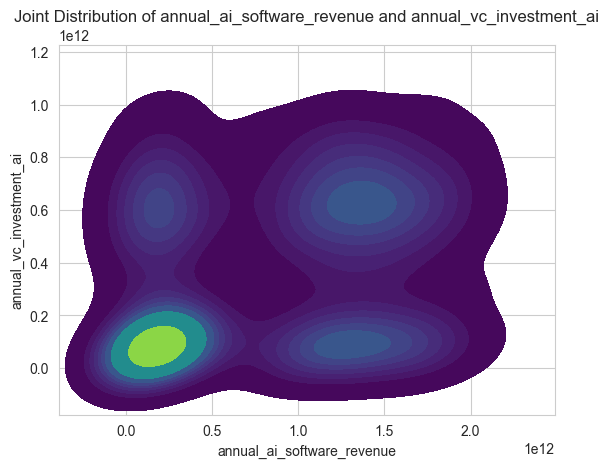

In [33]:
import seaborn as sns
sns.set_style("whitegrid")
# samples = samples[::5, :]
i1, i2 = 1, 4
sns.kdeplot(x=samples[:, i1], y=samples[:, i2], fill=True, thresh=0.01, cmap="viridis")
plt.xlabel(variables[i1].name)
plt.ylabel(variables[i2].name)
plt.title(f"Joint Distribution of {variables[i1].name} and {variables[i2].name}")

## Step 5: Build the maximum entropy distribution

## Step 6: Visualize the distribution

## Step 7: Get all marginal distributions

In [21]:
# Get marginal distributions for all variables
all_marginals = builder.get_all_marginals(info)

print(f"Computed marginals for {len(all_marginals)} variables:")
for var_name, dist in all_marginals.items():
    bin_centers = (np.array(dist.bin_edges[:-1]) + np.array(dist.bin_edges[1:])) / 2
    mean = np.sum(np.array(dist.bin_probabilities) * bin_centers)
    print(f"  {var_name}: mean = {mean:.2f}, bins = {len(dist.bin_edges)-1}")

Computed marginals for 7 variables:
  ai_bubble_bursts_by_2030: mean = 0.45, bins = 2
  top_5_ai_firms_revenue_2029: mean = 403.88, bins = 10
  annual_ai_vc_funding_2029: mean = 157.68, bins = 10
  global_recession_before_2030: mean = 0.53, bins = 2
  top_model_mmlu_score_2028: mean = 95.01, bins = 10
  major_ai_regulation_enacted: mean = 0.61, bins = 2
  fortune_500_ai_adoption_2028: mean = 69.41, bins = 10


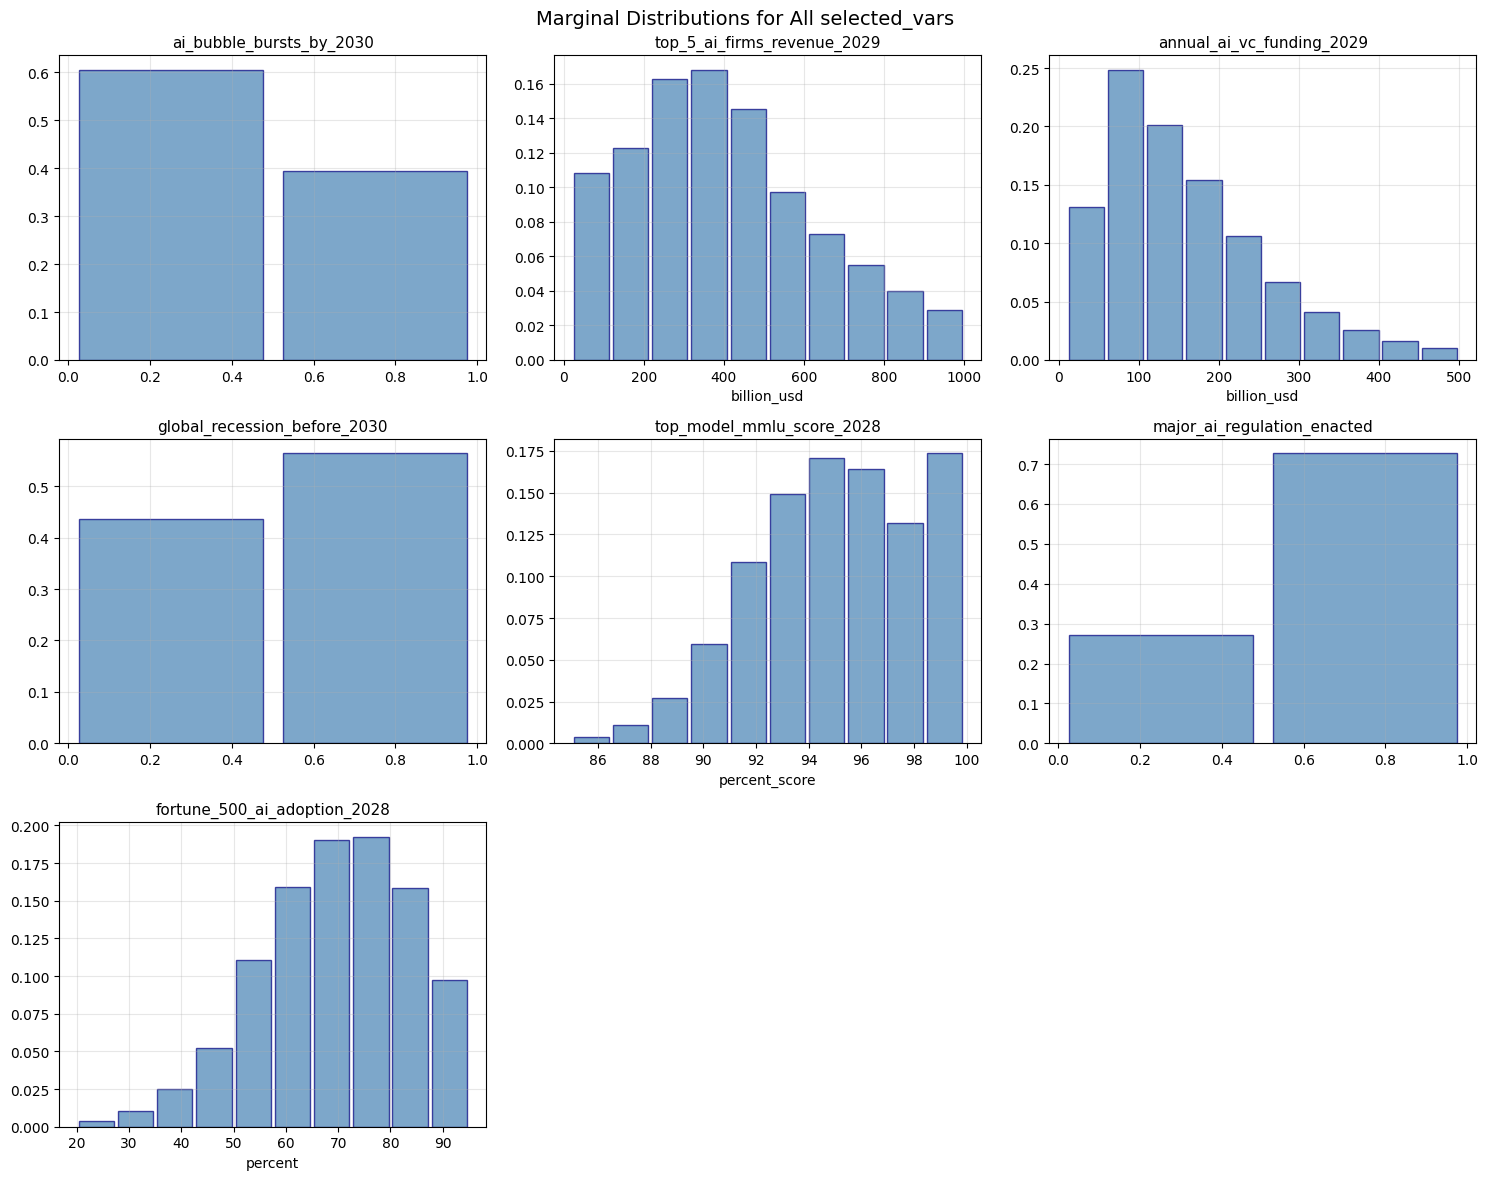

In [22]:
# Plot all marginals in a grid
n_vars = len(selected_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(selected_vars):
    ax = axes[idx]
    dist = all_marginals[var.name]
    
    bin_edges = np.array(dist.bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    probs = np.array(dist.bin_probabilities)
    
    ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
    ax.set_title(var.name, fontsize=11)
    ax.set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All selected_vars', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Pairwise Marginal Plot

Visualize the relationships between all pairs of variables using a lower triangular plot.
- **Diagonal**: 1D marginal distributions with mean indicator
- **Lower triangle**: 2D joint marginal heatmaps
- **Upper triangle**: Empty (symmetric information)

The target variable is placed in the first row/column for easy comparison.

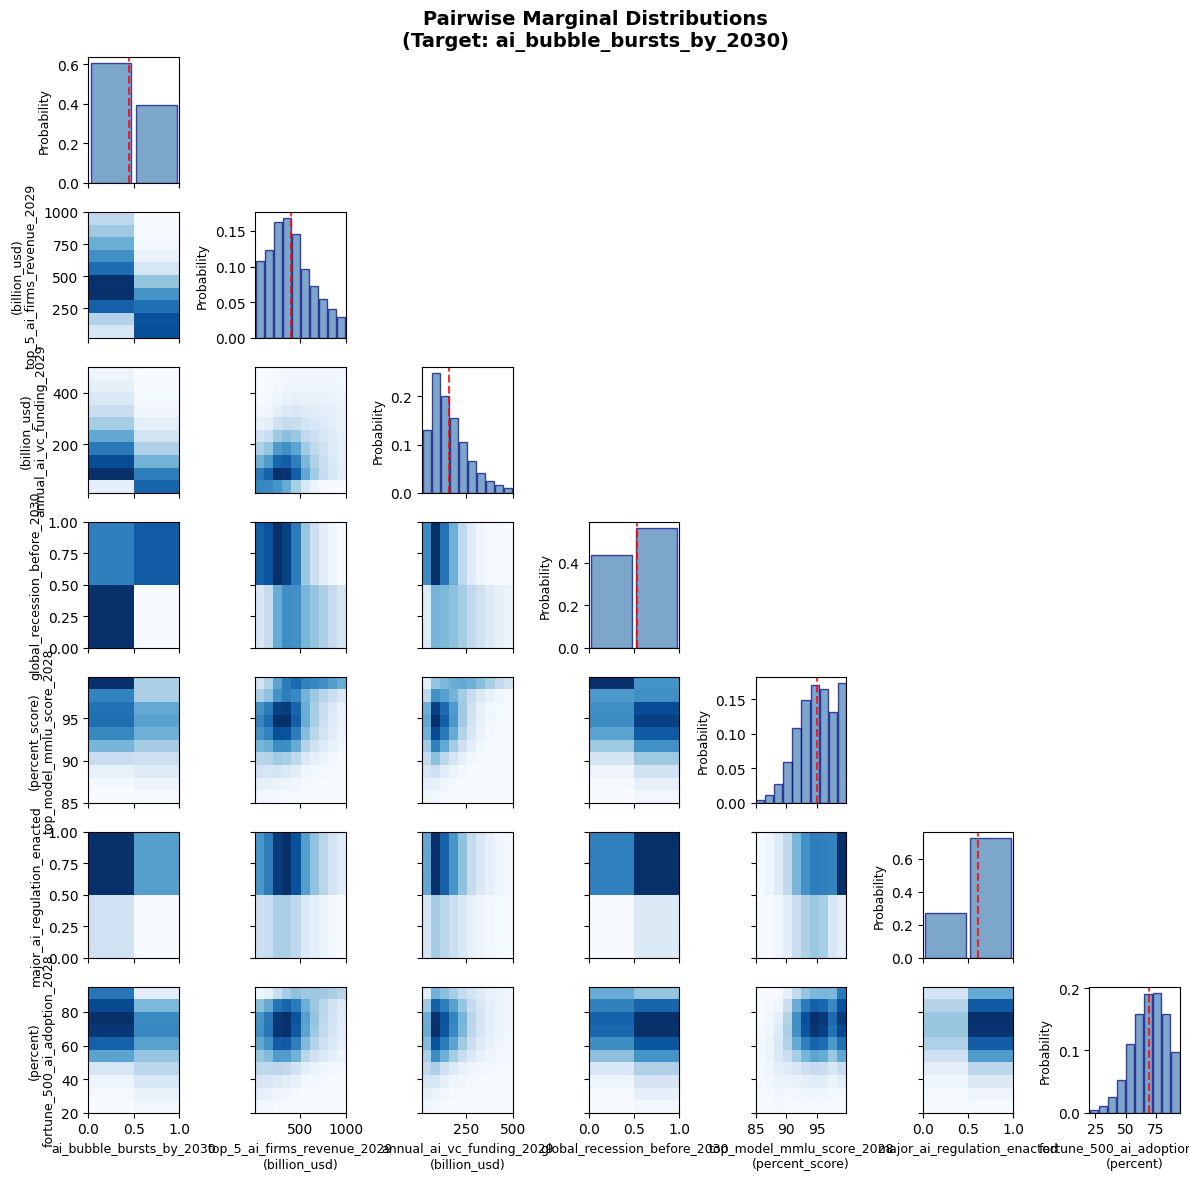

In [24]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=selected_vars,
    target_variable=target_var.name,
    constraints=[], #builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()